In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white', palette='bright')

import re
import pickle

plt.rcParams['figure.figsize'] = (15,9)


from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer

# ignore NMF warnings
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
links = pd.read_csv('../data/ml-latest-small/links.csv')
movies= pd.read_csv('../data/ml-latest-small/movies.csv')
tags = pd.read_csv('../data/ml-latest-small/tags.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
df = ratings.merge(movies, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
df['title']  = df.title.str[:-7]
df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


<AxesSubplot:>

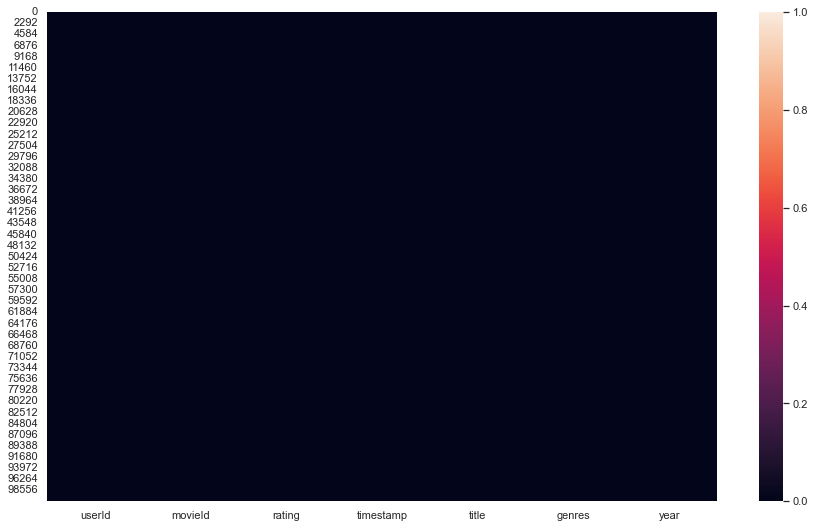

In [9]:
sns.heatmap(df.isna())

In [10]:
df.shape

(100836, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
 6   year       100819 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 6.2+ MB


In [12]:
df = df.dropna().reset_index(drop=True)

In [13]:
df = df.drop('timestamp', axis=1)
df.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [14]:
df['rating'].describe()

count    100819.000000
mean          3.501547
std           1.042474
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='count'>

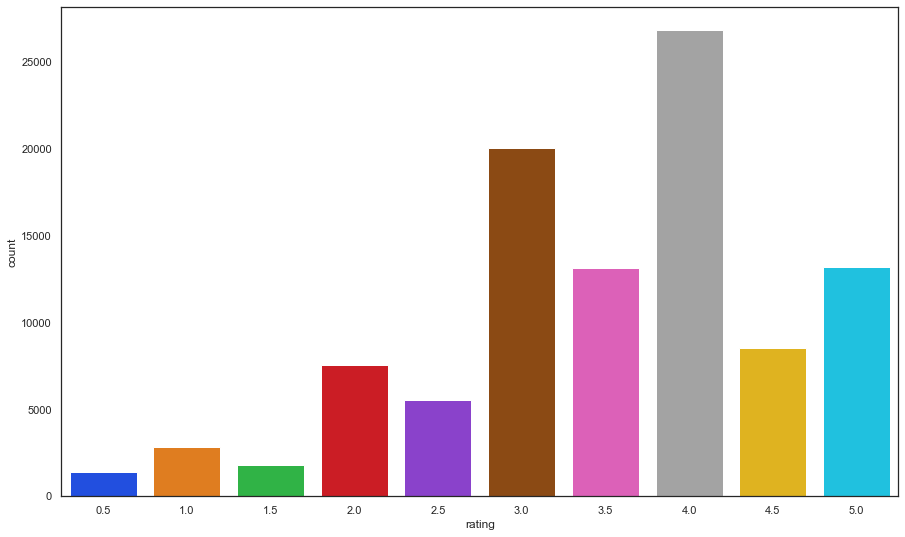

In [15]:
sns.countplot(data=df, x='rating')

<AxesSubplot:xlabel='year'>

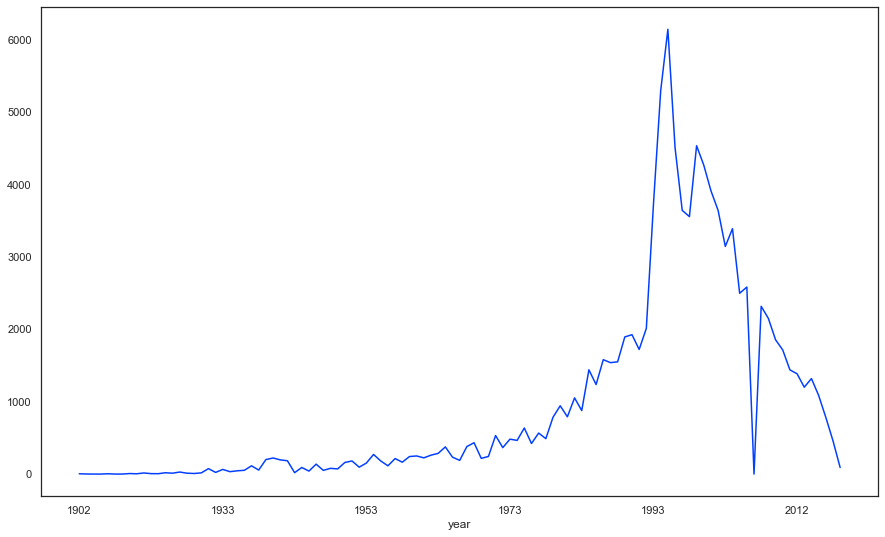

In [16]:
df.groupby('year').title.count().plot()

<AxesSubplot:xlabel='year'>

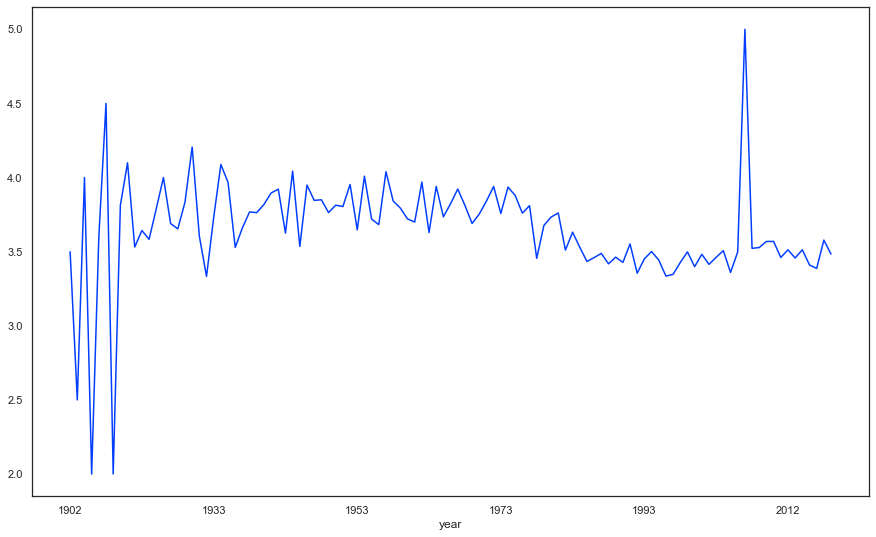

In [17]:
df.groupby('year').rating.mean().plot()

<AxesSubplot:ylabel='Frequency'>

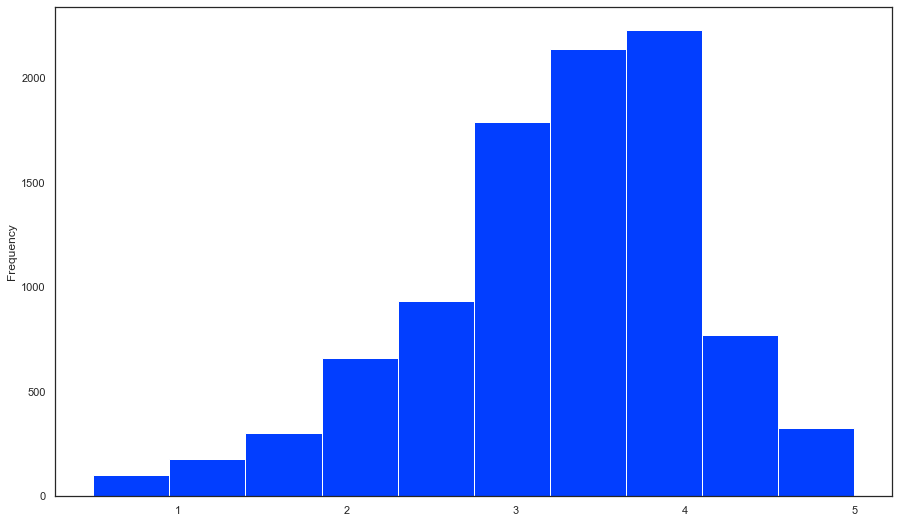

In [18]:
df.groupby('title').rating.mean().plot(kind='hist')

## 2. Non-negative Matrix Factorization (NMF)

In [19]:
nmf_df = df[['userId','title', 'rating']]
nmf_df = nmf_df.pivot_table(index='userId', columns='title', values='rating')

In [20]:
nmf_df.shape

(610, 9434)

In [21]:
nmf_df.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#in case we do not want NaNs with 0, we can drop the movies with few ratings and impute using the mean or median

#nmf_df = nmf_df.dropna(thresh=20, axis=1)

In [23]:
nmf_df = nmf_df.fillna(0)

In [24]:
nmf_df.shape

(610, 9434)

In [25]:
nmf_df.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#create a model and set the hyperparameters
# model assumes R ~ PQ'
n_components=20
nmf_model = NMF(n_components=n_components)
nmf_model.fit(nmf_df)

NMF(n_components=20)

In [27]:
Q = nmf_model.components_

In [28]:
Q =  pd.DataFrame(Q, 
                 columns=nmf_df.columns, 
                 index=[f"feature_{i+1}" for i in range(n_components)])  # movie-genre matrix
Q

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
feature_1,0.000000,0.000000,0.000000,0.000801,0.000000,0.000000,0.024005,0.000000,0.196912,0.095635,...,0.000000,0.366990,0.000000,0.000000,0.000000,0.000000,0.886025,0.415583,0.305192,0.000000
feature_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.070160,0.000000,0.000000,1.282002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.059948,0.100010,0.024717,0.000000,0.000000,0.000000
feature_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007339,...,0.003436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
feature_4,0.000000,0.043923,0.035626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.063883,0.019559,0.000000,0.000000,0.034004,0.000000,0.000000,0.136090,0.000000
feature_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.375673,0.179727,...,0.000000,0.033195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009264
feature_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.559361,0.000000,0.698141,0.000000,...,0.037774,0.000000,0.000000,0.000000,0.000000,0.666135,0.544877,0.000000,0.537419,0.000000
feature_7,0.000000,0.014874,0.023137,0.009451,0.046513,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.053277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019371,0.000000
feature_8,0.000000,0.000125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.759940,0.407379,0.000000,0.000000,0.000000
feature_9,0.000000,0.000000,0.000000,0.001929,0.004184,0.000000,0.127166,0.374806,0.000000,0.000000,...,0.375447,0.000000,0.000000,0.000000,0.000000,0.476929,0.000000,0.000000,0.360896,0.000000
feature_10,0.000000,0.009848,0.008055,0.007684,0.024064,0.000000,0.000000,0.000000,0.033445,0.003488,...,0.000000,0.023356,0.000000,0.000000,0.000000,0.012978,0.000000,0.000283,0.003994,0.000000


In [29]:
P = pd.DataFrame(nmf_model.transform(nmf_df),
             index=nmf_df.index,
            columns = [f"feature_{i+1}" for i in range(n_components)])
P

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
userId,,,,,,,,,,,,,,,,,,,,
1,0.058037,0.000000,0.046997,0.211114,0.031319,0.0,0.000000,0.029170,0.0,0.000000,0.000000,0.0,0.000000,0.136117,0.059493,1.989943,0.0,0.0,0.000000,0.000000
2,0.000000,0.092779,0.000000,0.193184,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.003504,0.0,0.010712,0.000000,0.000000,0.096345,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.116851,0.0,0.491861,0.161395,0.0,0.005692,0.000000,0.0,0.000000,0.017610,0.000000,0.057875,0.0,0.0,0.000000,0.782306
5,0.000000,0.000000,0.420903,0.036808,0.012866,0.0,0.045735,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.005109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,4.288414,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
607,0.012112,0.000000,0.229628,0.077271,0.000000,0.0,0.128977,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.227370,0.0,0.0,0.166496,0.000000
608,1.107586,0.000000,0.142784,0.000000,0.000000,0.0,0.000000,1.602288,0.0,0.000000,0.116839,0.0,0.000000,0.000000,0.000000,0.552332,0.0,0.0,1.840564,0.000000


In [30]:
nR = pd.DataFrame(np.dot(P, Q),
                  index=nmf_df.index,
                    columns=nmf_df.columns)
nR ## The reconstructed matrix!

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.011048,0.011909,0.007359,0.000000,0.000000,0.927348,0.0,0.124805,0.059164,...,0.000161,0.036510,0.004129,0.000000,0.000000,0.266090,0.063306,0.024119,1.169600,0.022298
2,0.000000,0.008485,0.006882,0.000000,0.000000,0.006509,0.000000,0.0,0.118943,0.000000,...,0.000000,0.012341,0.003778,0.000000,0.005562,0.015848,0.002293,0.000000,0.026290,0.000000
3,0.006291,0.000000,0.000000,0.000360,0.000001,0.000000,0.043497,0.0,0.005492,0.000000,...,0.003038,0.009611,0.007246,0.006478,0.000000,0.007395,0.004647,0.002351,0.053763,0.001066
4,0.000000,0.007590,0.011971,0.008964,0.031910,0.000000,0.029679,0.0,0.277789,0.026893,...,0.026205,0.004012,0.000000,0.000000,0.000000,0.566243,0.065749,0.000002,0.068297,0.001723
5,0.000000,0.002297,0.002369,0.000459,0.002185,0.000000,0.000000,0.0,0.030566,0.005401,...,0.003883,0.002779,0.000720,0.000000,0.000000,0.004048,0.000000,0.000000,0.006059,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.042234,0.034545,0.032954,0.103195,0.000000,0.000000,0.0,0.143427,0.014957,...,0.000000,0.100161,0.000000,0.000000,0.000000,0.055655,0.000000,0.001213,0.017127,0.000000
607,0.000000,0.007798,0.007640,0.005739,0.005999,0.000834,0.557821,0.0,0.002385,0.005631,...,0.008337,0.009381,0.001511,0.000000,0.000000,0.115280,0.050132,0.005034,0.701607,0.013574
608,0.000000,0.027675,0.021035,0.002917,0.000000,0.009214,0.337304,0.0,0.218097,0.137789,...,0.109262,0.515311,0.060202,0.060461,0.000000,1.507792,2.127444,0.461338,0.646239,0.006108


In [31]:
abs(nmf_df - nR)

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.011048,0.011909,0.007359,0.000000,0.000000,0.927348,0.0,0.124805,0.059164,...,0.000161,0.036510,0.004129,0.000000,0.000000,0.266090,0.063306,0.024119,2.830400,0.022298
2,0.000000,0.008485,0.006882,0.000000,0.000000,0.006509,0.000000,0.0,0.118943,0.000000,...,0.000000,0.012341,0.003778,0.000000,0.005562,0.015848,0.002293,0.000000,0.026290,0.000000
3,0.006291,0.000000,0.000000,0.000360,0.000001,0.000000,0.043497,0.0,0.005492,0.000000,...,0.003038,0.009611,0.007246,0.006478,0.000000,0.007395,0.004647,0.002351,0.053763,0.001066
4,0.000000,0.007590,0.011971,0.008964,0.031910,0.000000,0.029679,0.0,0.277789,0.026893,...,0.026205,0.004012,0.000000,0.000000,0.000000,0.566243,0.065749,0.000002,0.068297,0.001723
5,0.000000,0.002297,0.002369,0.000459,0.002185,0.000000,0.000000,0.0,0.030566,0.005401,...,0.003883,0.002779,0.000720,0.000000,0.000000,0.004048,0.000000,0.000000,0.006059,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.042234,0.034545,0.032954,0.103195,0.000000,0.000000,0.0,0.143427,0.014957,...,0.000000,0.100161,0.000000,0.000000,0.000000,0.055655,0.000000,0.001213,0.017127,0.000000
607,0.000000,0.007798,0.007640,0.005739,0.005999,0.000834,0.557821,0.0,0.002385,0.005631,...,0.008337,0.009381,0.001511,0.000000,0.000000,0.115280,0.050132,0.005034,0.701607,0.013574
608,0.000000,0.027675,0.021035,0.002917,0.000000,0.009214,0.337304,0.0,0.218097,0.137789,...,0.109262,0.515311,0.060202,0.060461,0.000000,2.992208,1.372556,0.461338,0.646239,0.006108


In [32]:
nmf_model.reconstruction_err_

873.2285909992577

**Save the model**

In [33]:
#filename = "my_nmf_model.sav"
#pickle.dump(nmf_model,open(filename, "wb"))
#pickle.dump(nmf_df, open('nmf_dataframe.sav', "wb"))
#pickle.dump(Q, open('Q_dataframe.sav', 'wb'))

## 3. Recommend movies for a new user

In [34]:
query = {'(500) Days of Summer': 5, 
         'Gladiator': 1, 
         'Groundhog Day': 1, 
         'Eternal Sunshine of the Spotless Mind':1, 
         'Dumb & Dumber (Dumb and Dumber)':1}

In [35]:
new_rec = pd.DataFrame.from_records(data=[query], index=['Finn'])
new_rec = new_rec.reindex(columns=nmf_df.columns)
new_rec

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
Finn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#make a copy
new_rec_copy = new_rec.copy()

In [37]:
R_new = new_rec.fillna(0)
R_new

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
Finn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
P_new = nmf_model.transform(R_new)
P_new

array([[0.00000000e+00, 4.35512196e-06, 0.00000000e+00, 1.21861913e-03,
        5.00337568e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.18736112e-03, 0.00000000e+00, 7.04549116e-03, 0.00000000e+00,
        0.00000000e+00, 1.36990648e-02, 0.00000000e+00, 0.00000000e+00]])

In [39]:
nR_new =  np.dot(P_new, Q)
nR_new

array([[1.87180394e-03, 8.23519471e-05, 8.31109436e-05, ...,
        7.19551106e-04, 3.68593847e-04, 4.63498625e-05]])

In [40]:
rec_df = pd.DataFrame(nR_new,
                                index=['Finn'],
                                columns=new_rec.columns)
rec_df

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
Finn,0.001872,0.000082,0.000083,0.000002,4.026038e-07,3.055560e-07,0.00028,0.0,0.028293,0.001166,...,0.0,0.002214,0.001643,0.001388,2.610790e-07,0.000943,0.006933,0.00072,0.000369,0.000046


In [41]:
unrated_boolean = np.isnan(new_rec_copy)
unrated_boolean = np.array(unrated_boolean)[0]
unrated_boolean

array([ True,  True,  True, ...,  True,  True,  True])

In [42]:
unrated_df = rec_df.iloc[:, unrated_boolean]
unrated_df

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
Finn,0.001872,0.000082,0.000083,0.000002,4.026038e-07,3.055560e-07,0.00028,0.0,0.001166,0.000045,...,0.0,0.002214,0.001643,0.001388,2.610790e-07,0.000943,0.006933,0.00072,0.000369,0.000046


In [43]:
sorted_new_user_df = unrated_df.T.sort_values(by="Finn", ascending=False)
sorted_new_user_df

,Finn
title,
Shrek,0.040713
Finding Nemo,0.037275
Forrest Gump,0.036516
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone),0.036329
Harry Potter and the Chamber of Secrets,0.036288
...,...
Gone,0.000000
Ruby in Paradise,0.000000
GoldenEye,0.000000


In [44]:
def recommend_nmf(query, name, model=nmf_model, k=10):    
    """Filters and recommends the top k movies 
    for any given input query based 
    on a trained NMF model.

    Parameters
    ----------
    query : dict
        A dictionary of movies already seen. 
        Takes the form {"movie_A": 3, "movie_B": 3} etc
    nmf_model : pickle
        pickle nmf_model read from disk
    k : int, optional
        no. of top movies to recommend, by default 10
    """
    # 1. candiate generation
    
    # construct a user vector
    
    new_rec = pd.DataFrame.from_records(data=[query], index=[name])
    new_rec = new_rec.reindex(columns=nmf_df.columns)
    
    new_rec_copy = new_rec.copy() #make a copy because we are transforming
    
    R = new_rec.fillna(0)
 
   
    # 2. scoring
    
    # calculate the score with the NMF nmf_model
    
    P = nmf_model.transform(R)
    R_hat =  np.dot(P, Q)
    
    rec_df = pd.DataFrame(R_hat,
                            index=[name],
                            columns=new_rec.columns)
    
    # 3. ranking
    
    # set zero score to movies already seen by the user
    unrated_boolean = np.isnan(new_rec_copy)
    unrated_boolean = np.array(unrated_boolean)[0]
    
    unrated_df = rec_df.iloc[:, unrated_boolean]
    
    
    # return the top-k highst rated movie ids or titles
    sorted_recs = unrated_df.T.sort_values(by=name, ascending=False)
    
    return sorted_recs.head(k)

In [45]:
recommend_nmf(query, 'Finn', k=15)

,Finn
title,
Shrek,0.040713
Finding Nemo,0.037275
Forrest Gump,0.036516
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone),0.036329
Harry Potter and the Chamber of Secrets,0.036288
"Amelie (Fabuleux destin d'Amélie Poulain, Le)",0.035041
Harry Potter and the Prisoner of Azkaban,0.034977
Juno,0.034613
"Beautiful Mind, A",0.034390


## 4. Neighborhood-based Collaborative Filtering

In [46]:
ncf_df = df[['userId','title', 'rating']]
ncf_df = ncf_df.pivot_table(index='userId', columns='title', values='rating')

In [47]:
ncf_df = ncf_df.sub(ncf_df.mean(axis=1), axis=0)

In [48]:
ncf_df = ncf_df.fillna(0)
ncf_df.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.373362,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [49]:
cosine_table=pd.DataFrame(cosine_similarity(ncf_df), 
                          index=ncf_df.index,
                          columns=ncf_df.index)
cosine_table.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001279,0.000590,0.049433,0.022008,-0.047110,-0.013769,0.047964,0.019495,-0.008565,...,0.018306,-0.018415,-0.017309,-0.038083,-0.030076,0.012316,0.056576,0.077001,-0.026641,0.004367
2,0.001279,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011277,-0.048085,0.000000,0.003012,...,-0.049020,-0.031581,-0.001703,0.000000,0.000000,0.006254,-0.020504,-0.005949,-0.060091,0.025043
3,0.000590,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017863,0.000000,-0.001437,-0.037490,-0.007789,-0.013147,0.000000,0.019609
4,0.049433,-0.017164,-0.011260,1.000000,-0.029620,0.011498,0.058999,0.002065,-0.005874,0.051590,...,-0.037687,0.060523,0.029643,-0.013782,0.040044,0.017081,0.014628,-0.037884,-0.017884,-0.000992
5,0.022008,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010269,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027204,0.012461,-0.036334,0.029234,0.031896,-0.001783,0.093829,-0.000285


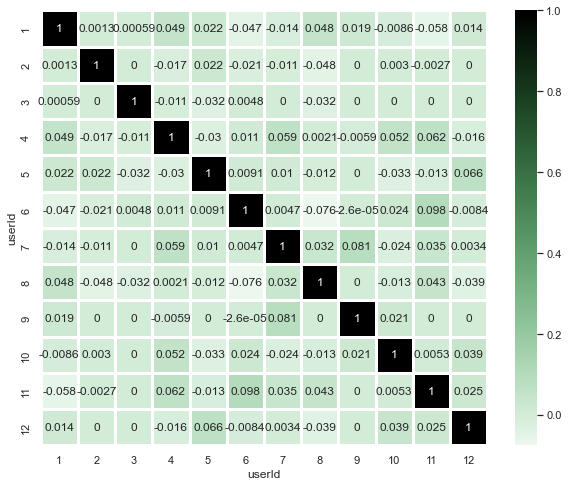

In [50]:
plt.figure(figsize=(10,8))
sns.heatmap(cosine_table.iloc[:,:12].head(12), 
            annot=True, 
            linewidths=3, 
            cmap=sns.cubehelix_palette(start=2, 
                                       rot=0, 
                                       dark=.95, #0,
                                       light=0, #.95#
                                       reverse=True,
                                       as_cmap=True));

In [51]:
Finn = {'(500) Days of Summer': 5, 
         'Gladiator': 4, 
         'Groundhog Day': 4, 
         'Eternal Sunshine of the Spotless Mind':5, 
         'Dumb & Dumber (Dumb and Dumber)':1}

In [52]:
def neighbor_recs(movie_ratings, k_neighbours=20, name="Default", number_of_recs=20):
    
    """
    Outputs movie recommendations based on a user's own rating using neighbourhood-based collaborative filtering.
    
    movie_ratings: dictionary input with movies keys and rating values (ideally 1-5)
    k_neighbors: number of neighbours the function is supposed to take into account
    name: Optional name of user
    number_of_rec: How many recommendations should be in the output
    
    """
    
    predicted_ratings_movies = []
    
    new_rec = pd.DataFrame.from_records(data=[movie_ratings], index=[name]) #create a dataframe from a dict
    user_mean = new_rec.mean(axis=1) #take user mean so we can calculate proper ratings later
    new_rec = new_rec.reindex(columns=ncf_df.columns) #add missing movie columns
    new_rec = new_rec.sub(new_rec.mean(axis=1), axis=0) #substract mean rating to normalize
    new_rec = new_rec.fillna(0) #fill with 0 for simplicity
    new_rec_T = new_rec.T #transpose to get an easy list in the next steps
    ncf_df_T = ncf_df.T
    
    unseen_movies = list(new_rec_T.index[new_rec_T[name]==0]) #isolate unseen movies
    
    full_df = pd.concat([ncf_df,new_rec]) #combine the new user with existing users
    
    cosine_table=pd.DataFrame(cosine_similarity(full_df), 
                          index=full_df.index,
                          columns=full_df.index) #calculate cosine similarity
    
    neighbours = list(cosine_table[name].sort_values(ascending=False).index[1:k_neighbours]) #create a list of neighbours
    
    for movie in unseen_movies:

        #list people who watched the unseen movies
        others = list(ncf_df_T.columns[ncf_df_T.loc[movie] != 0])
        
        #define base
        numerator = 0
        denominator = 0.000001 #avoid zero-division
        
        # go through users who are similar but watched the film
        for user in neighbours:
            if user in others:
            #  extract the ratings and similarities for similar users
                rating = ncf_df_T.loc[movie, user]
                similarity = cosine_table.loc[name, user]

            # predict rating based on the (weighted)
            # averaged rating of the neighbours
            # sum(ratings)/no.users OR 
            # sum(ratings*similarity)/sum(similarities)
                numerator = numerator + rating * similarity
                denominator = denominator + similarity
        predicted_ratings = round(numerator/denominator, 1)
        predicted_ratings_movies.append([predicted_ratings, movie])
        
        predicted_rating_df = pd.DataFrame(predicted_ratings_movies, columns=["rating", "movie"])
        final_recommendations = predicted_rating_df.sort_values("rating", ascending=False)
        final_recommendations['rating'] = final_recommendations['rating'] + user_mean[0]
        final_recommendations['rating'] = final_recommendations['rating'].values[final_recommendations['rating'] > 5.0] = 5.0
        
        final_recommendations = final_recommendations.head(number_of_recs)

    return final_recommendations

In [53]:
neighbor_recs(Finn, k_neighbours=25, number_of_recs=50)

,rating,movie
2840,5.0,Fantasia
8940,5.0,Wag the Dog
5946,5.0,"Ninth Gate, The"
4989,5.0,Living in Oblivion
8972,5.0,Wallace & Gromit: The Best of Aardman Animation
5227,5.0,"Man Without a Face, The"
4121,5.0,Ikiru
132,5.0,8 1/2 (8½)
8451,5.0,Three Colors: Blue (Trois couleurs: Bleu)
4174,5.0,In the Mood For Love (Fa yeung nin wa)


**Save the data frame**

In [54]:
#pickle.dump(ncf_df, open('ncf_dataframe.sav', "wb"))